In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch

def replace_unet_in_pipeline(pipe, path_to_weights=None, device='cuda'):
    unet = pipe.unet
    tmp = unet.conv_out
    n_noise_pred_channels = unet.conv_out.out_channels

    new_layer =  torch.nn.Conv2d(tmp.in_channels, tmp.out_channels * 2, kernel_size=tmp.kernel_size, padding=tmp.padding, bias=True, dtype=torch.float16) # Add 2 channels to serve for segmentation
    if path_to_weights:
        # load weights
        chkpt = torch.load(path_to_weights)
        new_layer.load_state_dict(chkpt['conv_out_state_dict'])
    else:
        # init weights to pipe weights
        new_layer.weight.data[:tmp.weight.data.shape[0], :, :, :] = tmp.weight.data[:, :, :, :]
    new_layer.to(device=device)
    unet.conv_out = new_layer
    return

import xml.etree.ElementTree as ET
import os

def get_annotations(img_paths, annotations_root):
    voc_classes = {'background' : 'background',
                    'aeroplane' : 'aeroplane',
                    'bicycle' : 'bicycle',
                    'bird' : 'bird',
                    'boat' : 'boat',
                    'bottle' : 'bottle',
                    'bus' : 'bus',
                    'car' : 'car',
                    'cat' : 'cat',
                    'chair' : 'chair',
                    'cow' : 'cow',
                    'diningtable' : 'dining table',
                    'dog' : 'dog',
                    'horse' : 'horse',
                    'motorbike' : 'motorbike',
                    'person' : 'person',
                    'pottedplant' : 'potted plant',
                    'sheep' : 'sheep',
                    'sofa' : 'sofa',
                    'train' : 'train',
                    'tvmonitor' : 'tv monitor'}

    images_names = [os.path.splitext(os.path.basename(path))[0] for path in img_paths]
    xmls_paths = [os.path.join(annotations_root, img_name +'.xml') for img_name in images_names]
    
    annotations = []
    for path in xmls_paths:
        tree = ET.parse(path)
        root = tree.getroot()
        annontation = root.find('object/name')

        annotations += [voc_classes[annontation.text]]

    return annotations

# Sample random pics and get their seg
import os
from os import walk
import random

def diffuse_random_imgs(img_folder, pipe, prompt, strength, guidance,neg_prompt=None, save_path=None):
    N_PICS = 9
    f = next(walk(img_folder), (None, None, []))[2]
    filenames = [os.path.join(img_folder, filename) for filename in f]
    filenames = random.sample(filenames, N_PICS)
    annotations_root = '/disk4/Lev/Projects/diffusion_finetuning/data/Annotations/'
    annotations = get_annotations(filenames, annotations_root)

    fig , ax = plt.subplots(N_PICS, 2,figsize=(15, 40))
    for i, item in enumerate(zip(filenames, annotations)):
        f, annotation = item
        init_image = Image.open(f).convert("RGB").resize((512, 512))
        ax[i, 0].imshow(init_image, aspect='auto')
        ax[i, 0].axis('off')
        
        full_prompt = prompt + ' ' + annotation
        image = pipe(prompt=full_prompt, image=init_image, strength=strength, guidance_scale=guidance, modified_unet=True, segmentation=True).images[0]
        ax[i, 1].imshow(image, aspect='auto')
        ax[i, 1].axis('off')
        ax[i, 1].set_title(full_prompt + ' ' + f)

        if save_path:
            if not os.path.exists(save_path):       
                os.mkdir(save_path)
            init_image.save(os.path.join(save_path, 'original_' + os.path.basename(f)))
            image.save(os.path.join(save_path, os.path.basename(f)))

    plt.show()



/opt/miniconda3/envs/lev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def get_good_slices(arr, s_indx=0):
    slices = []
    for i in range(s_indx, len(arr)):
        if arr[i].max() >= 1:
            slices.append(i)
            # classes = set(arr[i].flatten().tolist())
            # if len(classes) > 2:
            #     print('Found slice with more than 2 classes', i)
            #     print(classes)
    return slices

In [ ]:
import pickle
path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/lits_train_seg_files_tumor_slices.pickle'
with open(path, 'rb') as handle:
            loaded_dict = pickle.load(handle)

print(loaded_dict.keys())
        

In [5]:
# Save all paths with good slices
import os
from os import walk
import SimpleITK as sitk

'''
input: path to folder with ct slices and their segmentations
output: dict with key as path to ct and value as list of good slices
'''
def get_good_slices_from_path(img_folder):
    # get list of all files in folder
    f = next(walk(img_folder), (None, None, []))[2]
    # take only files with 'segmentation' in them
    filenames = [os.path.join(img_folder, filename) for filename in f if 'segmentation' in filename]

    good_seg_paths = {} # dict key is path and value is list of good slices
    good_vol_paths = {}
    for i, item in enumerate(filenames):
        f = item
        # check if f has '.nii' in it
        if '.nii' not in f:
            continue
        img = sitk.ReadImage(f, sitk.sitkUInt8)
        img = sitk.GetArrayFromImage(img)
        slices = get_good_slices(img)
        if len(slices) > 0:
            good_seg_paths[f] = slices
            vol_path = f.replace('segmentation', 'volume')
            good_vol_paths[vol_path] = slices
        # replace string 'segmnetation' with 'volume'
        
    return good_seg_paths, good_vol_paths

In [4]:
# save to pickle
import pickle
def save_to_pickle(object, path):
    with open(path, 'wb') as handle:
        pickle.dump(object, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Test Segmentation

In [68]:
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
import numpy as np
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers2.diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

PATH_PREFIX = '/disk4/Lev/Projects/diffusion_finetuning/output/lits17/w_text/ct_liver_segmentation_good_slices_only_run4'
UNET_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'unet_seg_weights.pt')
LORA_WEIGHTS_PATH = os.path.join(PATH_PREFIX, 'lora_weight.pt')
LORA_TEXT_WEIGHTS_PATH = os.path.join(PATH_PREFIX,'lora_weight.text_encoder.pt')

model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:3')

monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
monkeypatch_lora(pipe.text_encoder, torch.load(LORA_TEXT_WEIGHTS_PATH), target_replace_module=["CLIPAttention"])

tune_lora_scale(pipe.unet, 1)
tune_lora_scale(pipe.text_encoder, 1)

replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 5844.78it/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


(541, 512, 512)
177


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


decoding seg img


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


decoding seg img


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


decoding seg img


100%|██████████| 2/2 [00:00<00:00,  4.99it/s]


decoding seg img


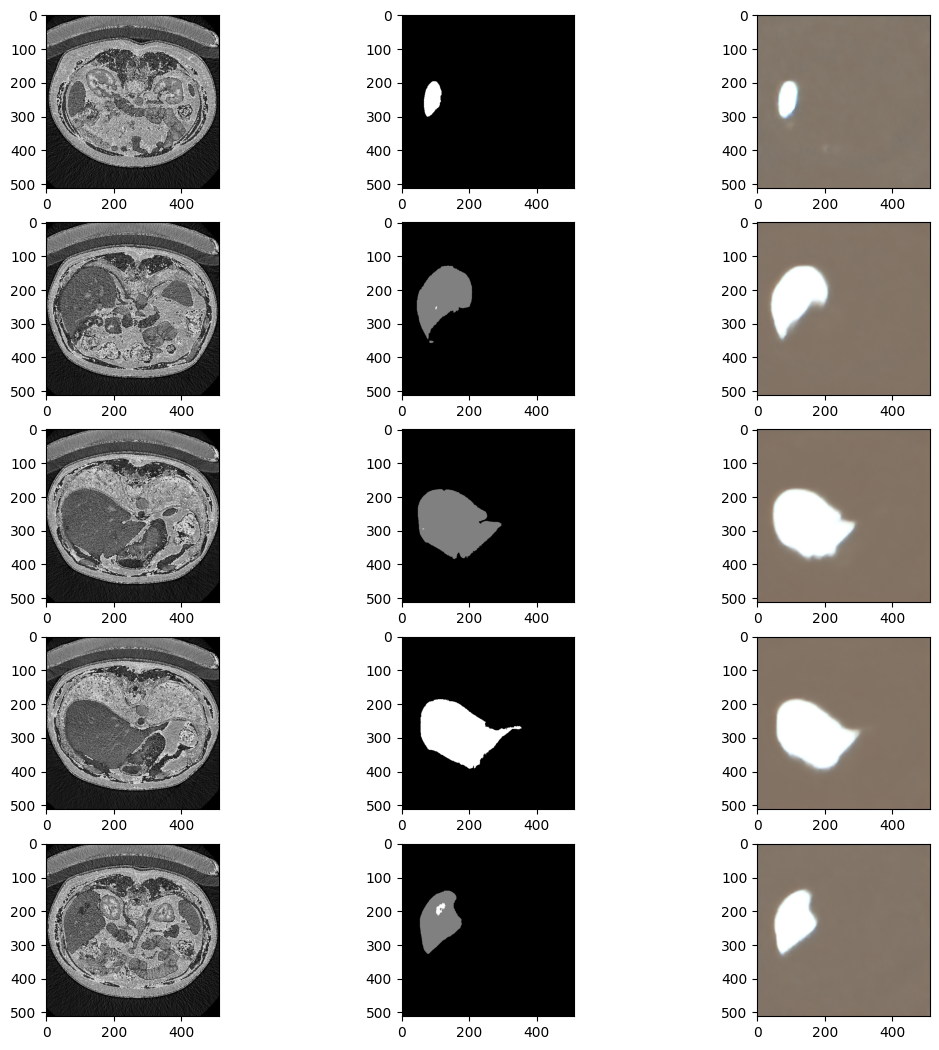

In [71]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

n = 7
PATH = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/test/'
seg_path = os.path.join(PATH,f'segmentation-{n}.nii')
path = os.path.join(PATH,f'volume-{n}.nii')

img = sitk.ReadImage(path, sitk.sitkUInt8)
seg_img = sitk.ReadImage(seg_path, sitk.sitkUInt8)

img = sitk.GetArrayFromImage(img)
seg_img = sitk.GetArrayFromImage(seg_img)
print(img.shape)

slices = get_good_slices(seg_img)
# slices = range(seg_img.shape[0])
print(len(slices))

n_examples = 5
indices = random.sample(slices, n_examples)
fig, ax = plt.subplots(n_examples, 3, figsize=(13,13))
seg_preds = []
seg_imgs = []
for i, indx in enumerate(indices):
    ax[i, 0].imshow(img[indx], cmap='gray')
    ax[i, 1].imshow(seg_img[indx], cmap='gray')
    seg_imgs += [seg_img[indx]]
    in_img = Image.fromarray(img[indx]).convert('RGB')
    output = pipe('segmentation map of liver', in_img, strength=0.05, guidance_scale=12, modified_unet=True, segmentation=True).images
    seg_preds += output
    ax[i, 2].imshow(output[0])

plt.show()


In [52]:
from training_scripts.segmentation_metrics import dice_coeff, iou_score,convert_seg_array_to_binary_rgb, convert_RGB_to_seg_mask, compute_mdice_miou_for_model_outputs

def test_mdice_miou(path, pipe, n_examples_per_ct=5):
    # get list of all files in folder
    f = next(walk(path), (None, None, []))[2]
    # take only files with 'segmentation' in them
    filenames = [os.path.join(path, filename) for filename in f if 'segmentation' in filename]

    mdice = []
    miou = []
    for i, item in enumerate(filenames):
        f = item
        vol_path = f.replace('segmentation', 'volume')
        # check if f has '.nii' in it
        if '.nii' not in f:
            continue
        
        seg_img = sitk.ReadImage(f, sitk.sitkUInt8)
        seg_arr = sitk.GetArrayFromImage(seg_img)
        img = sitk.ReadImage(vol_path, sitk.sitkUInt8)
        img_arr = sitk.GetArrayFromImage(img)
          
        slices = get_good_slices(seg_arr)
        indices = random.sample(slices, min(n_examples_per_ct, len(slices)))
                        
        for i in indices:
            ct_slice = img_arr[i]
            seg_slice = (seg_arr[i] * 256).clip(0, 255) # make all values be 0 or 255

            in_img = Image.fromarray(ct_slice).convert('RGB')
            output = pipe('segmentation map of liver', in_img, strength=0.05, guidance_scale=12, modified_unet=True, segmentation=True).images[0]
            output = convert_seg_array_to_binary_rgb(output)           
            output = convert_RGB_to_seg_mask(output)
            
            dice = dice_coeff(output, seg_slice)
            iou = iou_score(output, seg_slice)
            print(f'dice:{dice} iou:{iou}')
            mdice.append(dice)
            miou.append(iou)
            
    return np.mean(mdice), np.mean(miou), len(mdice)

In [58]:
print(f'mdice:{mdice}, miou:{miou}, nexamples{n_examples}')

mdice:0.7514588632673845, miou:0.6431366495685357, nexamples1437


In [73]:
mdice, miou, n_examples = test_mdice_miou(PATH, pipe, 1e3)
print(f'mdice:{mdice} miou:{miou}')

100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


decoding seg img
dice:0.894407734267595 iou:0.8089851584436422


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


decoding seg img
dice:0.8915642609111513 iou:0.8043445636677422


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.8302634696999074 iou:0.7097867324763343


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


decoding seg img
dice:0.9566581975788373 iou:0.9169173470849449


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


decoding seg img
dice:0.9373357751413329 iou:0.8820620410609921


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


decoding seg img
dice:0.7533926064576509 iou:0.6043543543543544


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


decoding seg img
dice:0.958260939835953 iou:0.9198665735784656


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


decoding seg img
dice:0.9321966835725334 iou:0.8730041096813312


100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


decoding seg img
dice:0.7878748560585173 iou:0.6499946478270178


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


decoding seg img
dice:0.9120507299529139 iou:0.8383210091344062


100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


decoding seg img
dice:0.9306819841308475 iou:0.87035098101698


100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


decoding seg img
dice:0.8187207173923995 iou:0.6930797225065393


100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


decoding seg img
dice:0.9349331713244229 iou:0.8778164394501169


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


decoding seg img
dice:0.8158551602489433 iou:0.688982574480045


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img
dice:0.8886874546773024 iou:0.799673735725938


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


decoding seg img
dice:0.9491525423728814 iou:0.9032258064516129


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


decoding seg img
dice:0.9425601176099968 iou:0.8913604766633565


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.9525631216526397 iou:0.9094229364499635


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


decoding seg img
dice:0.903598344792863 iou:0.8241490155559382


100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


decoding seg img
dice:0.9036399847451163 iou:0.8242182970664399


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.914480483782298 iou:0.8424357831618183


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.952996254681648 iou:0.9102128420676087


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


decoding seg img
dice:0.8742636668201521 iou:0.7766149506346968


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


decoding seg img
dice:0.5648601202704217 iou:0.39359237956432347


100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


decoding seg img
dice:0.935706124710037 iou:0.8791802212101496


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.9018244450114825 iou:0.8212024397327912


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.7533900465914095 iou:0.604351059873559


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


decoding seg img
dice:0.8928664704960563 iou:0.8064668323215802


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


decoding seg img
dice:0.9573059514963184 iou:0.9181081956592161


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.8931964596356406 iou:0.807005423330685


100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


decoding seg img
dice:0.8918573659059725 iou:0.8048218148696346


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


decoding seg img
dice:0.9515248256741998 iou:0.9075320512820513


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


decoding seg img
dice:0.9569721477577354 iou:0.9174943369925074


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


decoding seg img
dice:0.9538935862101182 iou:0.9118513887648477


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


decoding seg img
dice:0.9081675598327769 iou:0.8317829058950507


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.9375881339113177 iou:0.8825090944843181


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


decoding seg img
dice:0.9482342328000213 iou:0.9015640766902119


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9405946423314689 iou:0.8878515060575748


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


decoding seg img
dice:0.9127702250947181 iou:0.8395375532961626


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


decoding seg img
dice:0.9297999532444979 iou:0.8688094866593853


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9544487015751384 iou:0.9128664495114006


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


decoding seg img
dice:0.9464706542475592 iou:0.8983809118023008


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.9634853168469861 iou:0.9295433364398882


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


decoding seg img
dice:0.9344122354614974 iou:0.8768984278513969


100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


decoding seg img
dice:0.8668074196953702 iou:0.7649250751909717


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


decoding seg img
dice:0.9102566499056022 iou:0.8352945212528732


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


decoding seg img
dice:0.9532360059333281 iou:0.9106503579952268


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


decoding seg img
dice:0.801520045601368 iou:0.6687805187392987


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


decoding seg img
dice:0.8815648209427164 iou:0.7882127077635178


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


decoding seg img
dice:0.9463829787234043 iou:0.8982229402261712


100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


decoding seg img
dice:0.908435608112883 iou:0.8322327247615348


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


decoding seg img
dice:0.9497187183339739 iou:0.9042517798922084


100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


decoding seg img
dice:0.9232677653730286 iou:0.8574720210664911


100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


decoding seg img
dice:0.8963363160560527 iou:0.8121462444546428


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.9532823197744664 iou:0.9107348980377068


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


decoding seg img
dice:0.7264205124404839 iou:0.570377051088095


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


decoding seg img
dice:0.6515440271195588 iou:0.48317782725066916


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


decoding seg img
dice:0.9076131129775129 iou:0.8308531746031746


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9569883386851445 iou:0.9175241027302925


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


decoding seg img
dice:0.7675819741361513 iou:0.6228259876336389


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9503928170594838 iou:0.9054747647562019


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


decoding seg img
dice:0.9308807350074312 iou:0.8706986820725763


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


decoding seg img
dice:0.9478509608332111 iou:0.9008713837574067


100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


decoding seg img
dice:0.7082995294499432 iou:0.548346575385485


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


decoding seg img
dice:0.9396681749622926 iou:0.8862019914651493


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img
dice:0.9288557997255898 iou:0.8671622359413717


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


decoding seg img
dice:0.9545254510781869 iou:0.913006875263084


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


decoding seg img
dice:0.762744058662426 iou:0.6164804170088186


100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


decoding seg img
dice:0.9511782320010416 iou:0.906901688182721


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.9507165837964318 iou:0.9060627177700349


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


decoding seg img
dice:0.9378427101329527 iou:0.8829602913616916


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


decoding seg img
dice:0.965167663114115 iou:0.9326802310977141


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


decoding seg img
dice:0.8995033148808612 iou:0.8173612215683156


100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


decoding seg img
dice:0.6181225761895486 iou:0.44730637141831975


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


decoding seg img
dice:0.9478810319153218 iou:0.9009257134113687


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


decoding seg img
dice:0.8711795016587845 iou:0.7717608804402201


100%|██████████| 2/2 [00:00<00:00,  4.79it/s]


decoding seg img
dice:0.8876663633863016 iou:0.7980216853718851


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


decoding seg img
dice:0.9274314521086929 iou:0.8646826852531181


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


decoding seg img
dice:0.9371156516564174 iou:0.88167226577081


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


decoding seg img
dice:0.8912599740211542 iou:0.8038493723849373


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


decoding seg img
dice:0.9453468107354479 iou:0.8963579879701236


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9086436407641796 iou:0.8325819821129935


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


decoding seg img
dice:0.9625483692647872 iou:0.9278007193286266


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


decoding seg img
dice:0.9450674522143742 iou:0.8958558101161389


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


decoding seg img
dice:0.8878234338471293 iou:0.7982756163602679


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


decoding seg img
dice:0.5623089107452021 iou:0.39111942401803784


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


decoding seg img
dice:0.9141929499072357 iou:0.841947885519009


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


decoding seg img
dice:0.9568695972043406 iou:0.9173058273825266


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]


decoding seg img
dice:0.9145573723258662 iou:0.8425662941629284


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


decoding seg img
dice:0.943522178304787 iou:0.8930828067841703


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img
dice:0.9298129326852261 iou:0.8688321519510013


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


decoding seg img
dice:0.8434078572085748 iou:0.7292180415241428


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.9338038108680311 iou:0.8758273762245168


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


decoding seg img
dice:0.9203287847856452 iou:0.8524157834502663


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


decoding seg img
dice:0.9534100477126017 iou:0.9109680879592384


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


decoding seg img
dice:0.8958638797012991 iou:0.81137086563108


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


decoding seg img
dice:0.9244470484839608 iou:0.8595086343084382


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.9458852245305522 iou:0.8973265972002947


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


decoding seg img
dice:0.9430049451926802 iou:0.8921564399982752


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


decoding seg img
dice:0.8969502175836478 iou:0.813154793085385


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


decoding seg img
dice:0.94072917917317 iou:0.8880912800362702


100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


decoding seg img
dice:0.9326401946687314 iou:0.8737823834196892


100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.7350467435825282 iou:0.58108609140569


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.9540710659898477 iou:0.9121758036962261


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img
dice:0.8802948208919209 iou:0.7861844683018572


100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


decoding seg img
dice:0.9370077512125891 iou:0.8814812641215998


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9310373652093956 iou:0.8709727869878011


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


decoding seg img
dice:0.9431030862901533 iou:0.8923321414382201


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


decoding seg img
dice:0.7135273778023083 iou:0.5546386028669493


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


decoding seg img
dice:0.9167365118896525 iou:0.846272880007074


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


decoding seg img
dice:0.9067220543806647 iou:0.8293609671848013


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


decoding seg img
dice:0.9413445305398035 iou:0.8891887471377167


100%|██████████| 2/2 [00:00<00:00,  4.88it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


decoding seg img
dice:0.9530218068535825 iou:0.9102594620328494


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


decoding seg img
dice:0.8889499020738382 iou:0.8000988467874794


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


decoding seg img
dice:0.8015569167942828 iou:0.6688318602917687


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


decoding seg img
dice:0.897270665284725 iou:0.8136816869176702


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.9332400129212878 iou:0.87483597456344


100%|██████████| 2/2 [00:00<00:00,  5.70it/s]


decoding seg img
dice:0.7229503409656973 iou:0.566109810884244


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


decoding seg img
dice:0.9256015399422521 iou:0.8615067634148527


100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


decoding seg img
dice:0.9304546889801073 iou:0.8699535021034762


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


decoding seg img
dice:0.947098976109215 iou:0.899513776337115


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


decoding seg img
dice:0.7115808170515098 iou:0.5522898342937494


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


decoding seg img
dice:0.9224312468365109 iou:0.8560300622382275


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


decoding seg img
dice:0.9429368501141263 iou:0.8920345489443378


100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


decoding seg img
dice:0.939508276533593 iou:0.8859175943991736


100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


decoding seg img
dice:0.9534711746088088 iou:0.911079706048615


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img
dice:0.8301662118580997 iou:0.709644583934176


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.8792745345300794 iou:0.7845583611874111


100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


decoding seg img
dice:0.9501182033096927 iou:0.9049763566764242


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


decoding seg img
dice:0.9595685111989459 iou:0.9222793826671943


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.9625720947355504 iou:0.9278448071918618


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


decoding seg img
dice:0.9079873015873016 iou:0.8314805339783246


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9497774952320407 iou:0.9043583535108959


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.8367309681737967 iou:0.7192927390667504


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.8660576341774703 iou:0.7637580712043125


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.9290063249985222 iou:0.8674246605585606


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.9074556968761641 iou:0.8305893813930832


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


decoding seg img
dice:0.930937007171125 iou:0.8707971498552661


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


decoding seg img
dice:0.9448293725312439 iou:0.8954280454127033


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


decoding seg img
dice:0.9134438305709024 iou:0.8406779661016949


100%|██████████| 2/2 [00:00<00:00,  5.08it/s]


decoding seg img
dice:0.965788257050393 iou:0.9338399642378185


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


decoding seg img
dice:0.9028836733824595 iou:0.822960748534379


100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


decoding seg img
dice:0.9485696779381917 iou:0.902170745920746


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


decoding seg img
dice:0.9150864472950363 iou:0.8434648502763141


100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


decoding seg img
dice:0.7025199864074544 iou:0.5414495630358669


100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


decoding seg img
dice:0.9223574631646381 iou:0.8559029841873736


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


decoding seg img
dice:0.8970877944325482 iou:0.8133809653244283


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.8678535645472062 iou:0.7665559307265004


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


decoding seg img
dice:0.8965932420542426 iou:0.8125681989871576


100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


decoding seg img
dice:0.9109983746244398 iou:0.8365445499773858


100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


decoding seg img
dice:0.9510608203677511 iou:0.906688241639698


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.946597250366306 iou:0.8986090559337082


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.8728356336260978 iou:0.7743641119830801


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


decoding seg img
dice:0.05853658536585366 iou:0.03015075376884422


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.8770225067732219 iou:0.7809795940372537


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


decoding seg img
dice:0.9388831556014219 iou:0.8848065701318348


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.9431529823537991 iou:0.892421482585417


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


decoding seg img
dice:0.8890517532980042 iou:0.8002638790216178


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.9214436452904948 iou:0.8543305514515034


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


decoding seg img
dice:0.8972419518494604 iou:0.8136344625679632


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.951927872626127 iou:0.9082656124167215


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img
dice:0.9119885139985643 iou:0.8382158880971232


100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


decoding seg img
dice:0.9050687285223368 iou:0.8265986661435857


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


decoding seg img
dice:0.7688760621059929 iou:0.6245318106812646


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


decoding seg img
dice:0.9102292094188028 iou:0.8352483084386569


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.7791324435318275 iou:0.6381793335435719


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


decoding seg img
dice:0.8558711006474397 iou:0.7480547874734744


100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


decoding seg img
dice:0.9477243172951886 iou:0.9006426099851705


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


decoding seg img
dice:0.7620808523973676 iou:0.615614399270923


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


decoding seg img
dice:0.8666642050070157 iou:0.7647020493272082


100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


decoding seg img
dice:0.9537088678192973 iou:0.9115138592750534


100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


decoding seg img
dice:0.8215882073228721 iou:0.6971995803405697


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


decoding seg img
dice:0.44598771320639524 iou:0.2869911113293719


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


decoding seg img
dice:0.9272994608724064 iou:0.8644532439841608


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


decoding seg img
dice:0.9426212024255721 iou:0.8914697406340057


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.9535793454166124 iou:0.9112772585669782


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9616749467707594 iou:0.9261790840738209


100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


decoding seg img
dice:0.9056983711979734 iou:0.8276496601668002


100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


decoding seg img
dice:0.9208594960450135 iou:0.853326784297427


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


decoding seg img
dice:0.6857240262507458 iou:0.5217504085497133


100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


decoding seg img
dice:0.88045597720114 iou:0.7864415862808146


100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


decoding seg img
dice:0.8773295936819574 iou:0.781466749942474


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


decoding seg img
dice:0.909716843101816 iou:0.8343858541206188


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


decoding seg img
dice:0.8505451602152073 iou:0.7399552646839532


100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


decoding seg img
dice:0.9023388680592751 iou:0.8220559531554977


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


decoding seg img
dice:0.9591373439273553 iou:0.9214830970556162


100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


decoding seg img
dice:0.9600482638423381 iou:0.9231661724893645


100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


decoding seg img
dice:0.9109736077787599 iou:0.8365027829313544


100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


decoding seg img
dice:0.7654396571516032 iou:0.6200099181750558


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


decoding seg img
dice:0.9202508960573477 iou:0.8522821576763485


100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


decoding seg img
dice:0.9498853008646551 iou:0.9045538564947068


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


decoding seg img
dice:0.9411499436302142 iou:0.8888415672913118


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


decoding seg img
dice:0.9131917272219117 iou:0.8402509900735483


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]


decoding seg img
dice:0.9590071455434374 iou:0.921242774566474


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.662493932503896 iou:0.49532031936432747


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.8701019089995694 iou:0.7700711382113821


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


decoding seg img
dice:0.9060082304526749 iou:0.8281673186879326


100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


decoding seg img
dice:0.950467513785663 iou:0.905610380116959


100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


decoding seg img
dice:0.9221439482023573 iou:0.8555353441346927


100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


decoding seg img
dice:0.16782522343594836 iou:0.0915989159891599


100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


decoding seg img
dice:0.5890390759400344 iou:0.4174736988782833


100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


decoding seg img
dice:0.8622819609378398 iou:0.7579047983177213


100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


decoding seg img
dice:0.8937107715716731 iou:0.8078454970056449


100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


decoding seg img
dice:0.0 iou:0.0


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.9247564497968375 iou:0.860043707885631


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


decoding seg img
dice:0.9076926327354166 iou:0.8309864603481625


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.873662180327032 iou:0.7756662033959756


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


decoding seg img
dice:0.8801624915368991 iou:0.7859733978234583


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


decoding seg img
dice:0.9174032886607737 iou:0.8474100087796312


100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


decoding seg img
dice:0.9522587615639139 iou:0.9088682650167569


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


decoding seg img
dice:0.8431043427838985 iou:0.728764376912525


100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


decoding seg img
dice:0.959569009748589 iou:0.9222803037774928


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


decoding seg img
dice:0.905342923195479 iou:0.8270562008682388


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


decoding seg img
dice:0.9500196515131665 iou:0.9047975544325909


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


decoding seg img
dice:0.9135941786485593 iou:0.8409326981625417


100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


decoding seg img
dice:0.8665934669228658 iou:0.7645919108743037


100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


decoding seg img
dice:0.9504375295014705 iou:0.9055559399432643


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.9306784660766961 iou:0.8703448275862069


100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


decoding seg img
dice:0.9288617235751544 iou:0.8671725621414914


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]


decoding seg img
dice:0.899680139575458 iou:0.8176532769556025


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


decoding seg img
dice:0.8432746946136309 iou:0.729018973378438


100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


decoding seg img
dice:0.9369882703216037 iou:0.8814467838516515


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


decoding seg img
dice:0.9341610370640862 iou:0.8764560778402083


100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


decoding seg img
dice:0.957979456623238 iou:0.9193479559614236


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


decoding seg img
dice:0.7227657047026763 iou:0.565883414941051


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]


decoding seg img
dice:0.942426237357113 iou:0.8911210457812234


100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


decoding seg img
dice:0.9569098712446352 iou:0.9173798551678736


100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


decoding seg img
dice:0.9232841349121724 iou:0.8575002606066924


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


decoding seg img
dice:0.9353117705901968 iou:0.8784841841528344


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

[255 255 255] : 12291
[131 117 103] : 10631
[130 116 102] : 9806
[130 116 103] : 9612
[131 117 104] : 9515
[132 118 104] : 9093
[130 117 103] : 7991
[131 118 104] : 7582
[132 118 105] : 7276
[130 117 104] : 6880
[129 115 102] : 6812
[129 115 101] : 6364
[129 116 102] : 6328
[133 119 105] : 5993
[131 118 105] : 5952
[132 119 105] : 5746
[129 116 103] : 5735
[133 119 106] : 4450
[132 119 106] : 4048
[128 114 101] : 3666
[128 115 102] : 3483
[128 115 101] : 3404
[128 114 100] : 3172
[133 120 106] : 3061
[134 120 106] : 2663
[133 120 107] : 2200
[131 116 102] : 2155
[132 117 103] : 2008
[131 116 103] : 2007
[134 120 107] : 1978
[130 115 102] : 1797
[132 117 104] : 1774
[130 115 101] : 1612
[133 118 104] : 1536
[131 117 102] : 1342
[132 118 103] : 1251
[130 118 105] : 1246
[134 121 107] : 1226
[129 117 104] : 1225
[133 118 105] : 1225
[129 114 101] : 1205
[127 114 101] : 1126
[131 118 103] : 1102
[129 117 103] : 1089
[130 117 102] : 1079
[130 118 104] : 1076
[130 116 101] : 1073
[127 114 10

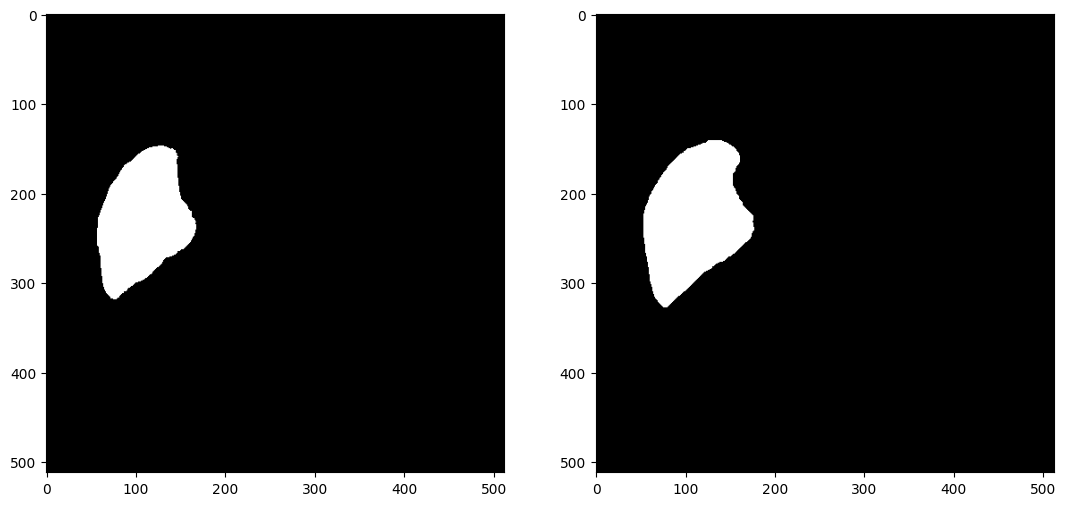

(512, 512)   (512, 512)
dice:0.9013970884822705 IoU:0.820493991989319


In [72]:
from training_scripts.segmentation_metrics import dice_coeff, iou_score,convert_seg_array_to_binary_rgb, convert_RGB_to_seg_mask, compute_mdice_miou_for_model_outputs
example_n = 4
seg = seg_preds[example_n]
seg_arr = np.array(seg)

# get unique rgb values from seg_arr
unique, count = np.unique(seg_arr.reshape(-1,3), axis=0, return_counts=True)
sorted_indices = np.argsort(count)[::-1]
unique_sorted = unique[sorted_indices]
count_sorted  = count[sorted_indices]

for i, (color, count) in enumerate(zip(unique_sorted, count_sorted)):
    print(color,':', count)

# plot example images side by side
seg_arr = convert_seg_array_to_binary_rgb(seg)
seg_pred_img = Image.fromarray(seg_arr)
seg_gt = (seg_imgs[example_n] * 256).clip(0,255)
real_seg_img = Image.fromarray(seg_gt).convert('RGB')
plot_2_imgs_side_by_side(seg_pred_img, real_seg_img)


# compute dice and iou scores
seg_pred = convert_RGB_to_seg_mask(seg_arr)

print(seg_gt.shape, ' ', seg_pred.shape)
dice = dice_coeff(seg_pred, seg_gt)
iou = iou_score(seg_pred, seg_gt)

print(f'dice:{dice} IoU:{iou}')


In [64]:
mdice, miou = compute_mdice_miou_for_model_outputs(seg_preds, seg_imgs)
print(f'mdice:{mdice} miou:{miou}')

mdice:0.9147699775644998 miou:0.843587353516966


In [11]:
def plot_2_imgs_side_by_side(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(13,13))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    plt.show()

In [151]:
# function to computs the most different pixels based on euclidean distance
# pixels is a np array of shape (N, 3) where N is the number of 
# returns the 3 pixels with the largest euclidean distance from each other
def get_most_different_pixels(pixels):
    # compute the euclidean distance between all pixels
    dist = np.linalg.norm(pixels[:, None] - pixels, axis=-1)
    # get the 3 pixels with the largest distance from each other
    max_dist = np.max(dist, axis=0)
    max_dist = np.argsort(max_dist)[-3:]
    return pixels[max_dist]

In [160]:
# function that replaces all pixels in array based on how close they are to the 3 inputs pixel values
# array is a np array of shape (H, W, 3)
# for each pixel in img_arr change in to (0,0,0) if its closest to the first pixel in seg_pixels
def convert_to_segmap(img_arr, seg_pixels):
    # Compute the Euclidean distance between each pixel and each input pixel
    distances = np.sqrt(np.sum((img_arr[..., np.newaxis, :] - seg_pixels[np.newaxis, np.newaxis, :, :])**2, axis=-1))

    # Find the indices of the closest input pixel for each pixel
    closest_indices = np.argmin(distances, axis=-1)

    # Create an array to store the result
    result = np.zeros_like(img_arr)

    # Replace each pixel with the corresponding color based on the closest input pixel
    result[closest_indices == 0] = [0, 0, 0]
    result[closest_indices == 1] = [128, 128, 128]
    result[closest_indices == 2] = [255, 255, 255]

    return result

[[159 148 131]
 [159 147 126]
 [202 200 185]]


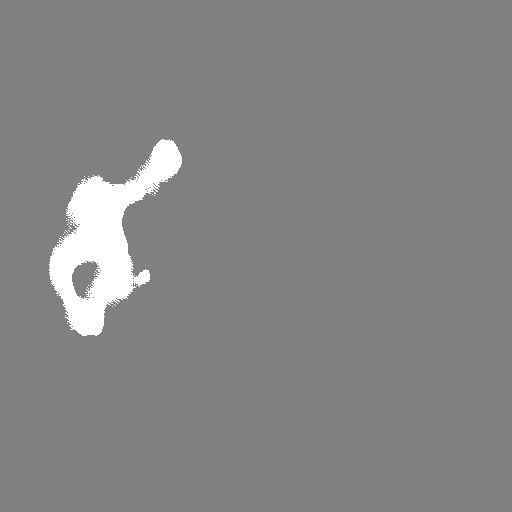

In [162]:
output_arr = np.array(output)
unique_pixels, counts = np.unique(output_arr.reshape(-1,3), axis=0, return_counts=True)
# for pixel, count in zip(unique_pixels, counts):
    # print(pixel, count)

# get two most common pixels
most_common = unique_pixels[np.argsort(counts)[-20:]]
represetive_pixels = get_most_different_pixels(unique_pixels)
print(represetive_pixels)
represetive_pixels = np.array([[0, 0, 0], [128, 128, 128], [255, 255, 255]])
segmap = convert_to_segmap(output_arr, represetive_pixels)
segmap_img = Image.fromarray(segmap)
segmap_img

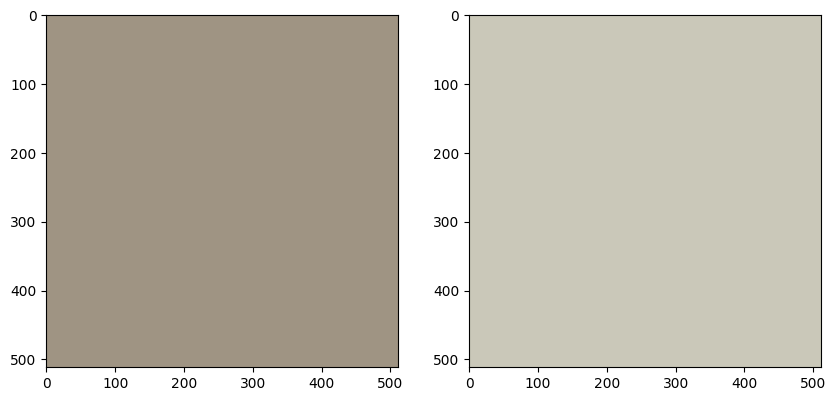

In [155]:
# create image with color (134, 118, 100)
img1 = Image.new('RGB', (512, 512), color = (159, 148, 131))
img2 = Image.new('RGB', (512, 512), color = (202, 200, 185))

# plot img1 and img2 side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [7]:
import numpy as np

def convert_segmap_to_rgb(seg_arr):
    print(seg_arr.shape)
    seg_arr = seg_arr.astype(np.uint16)
    seg_arr = seg_arr * 128
    seg_arr = Image.fromarray(seg_arr).convert('RGB')

    return seg_arr

In [88]:
def convert_segmap_to_rgb_hard(seg_arr):
    seg_arr = seg_arr.astype(np.uint8)
    # create an empty image with the same shape as the input array
    image = np.zeros((seg_arr.shape[0], seg_arr.shape[1], 3), dtype=np.uint8)
    
    # convert 0 values to (0, 0, 0)
    image[seg_arr == 0] = [0, 0, 0]
    
    # convert 1 values to (128, 128, 128)
    image[seg_arr == 1] = [128, 128, 128]
    
    # convert 2 values to (255, 255, 255)
    image[seg_arr == 2] = [255, 255, 255]
    
    # convert the numpy array to a PIL image
    return Image.fromarray(image)

In [21]:
path = os.path.join(PATH,f'volume-{n}.nii')

img = sitk.ReadImage(path, sitk.sitkUInt8)
img_arr = sitk.GetArrayFromImage(img)[337].astype(np.uint16)


In [ ]:
seg_img = Image.fromarray(img_arr).convert('RGB')

seg_arr = np.array(seg_img)
print(seg_arr.shape)
print(set(seg_arr.flatten().tolist()))
seg_arr = seg_arr.reshape(-1,3)
unique_pixels = np.unique(seg_arr, axis=0, return_counts=False)
print(unique_pixels)

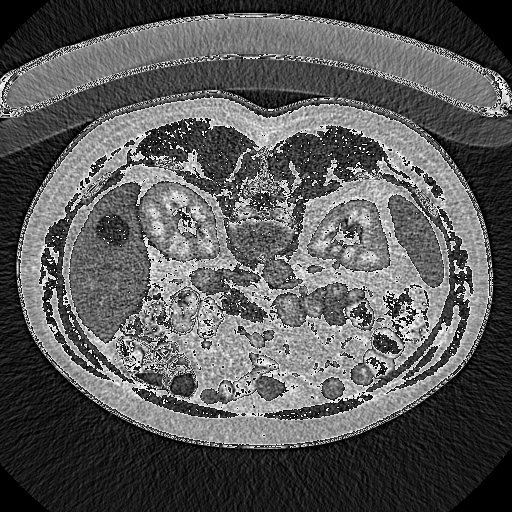

In [19]:
seg_img

In [9]:
import os
import fnmatch
import pickle

def list_files(directory, substring):
    files = []
    for root, dir, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, substring + '*'):
            files.append(os.path.join(root, filename))
    return files

seg_files = list_files(PATH, 'segmentation')
# print(len(seg_files), '\n', len(vol_files))

seg_files_w_good_slices = {}
for path in seg_files:
    img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(img)
    good_slices = get_good_slices(img_arr)
    seg_files_w_good_slices[path] = good_slices

KeyboardInterrupt: 

In [7]:
seg_files_w_good_slices

NameError: name 'seg_files_w_good_slices' is not defined

### Test LITS17 DS

In [6]:
ct_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/volume-102.nii'
seg_path = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train/segmentation-102.nii'

ct = sitk.ReadImage(ct_path, sitk.sitkUInt8)
seg = sitk.ReadImage(seg_path, sitk.sitkUInt8)

ct_array = sitk.GetArrayFromImage(ct)
seg_array = sitk.GetArrayFromImage(seg)

In [37]:
seg_img = Image.fromarray(seg_array*127)
ct_img = Image.fromarray(ct_array)

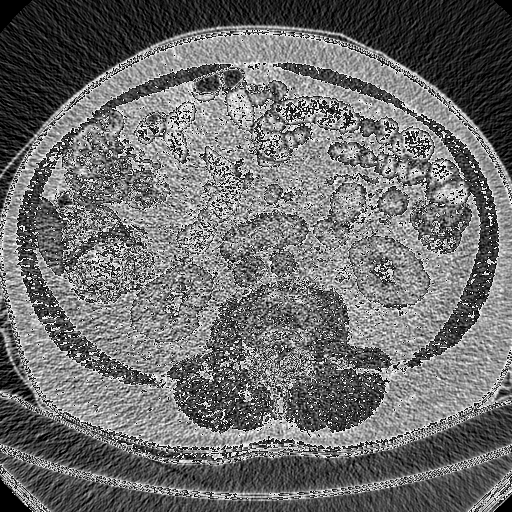

In [38]:
ct_img

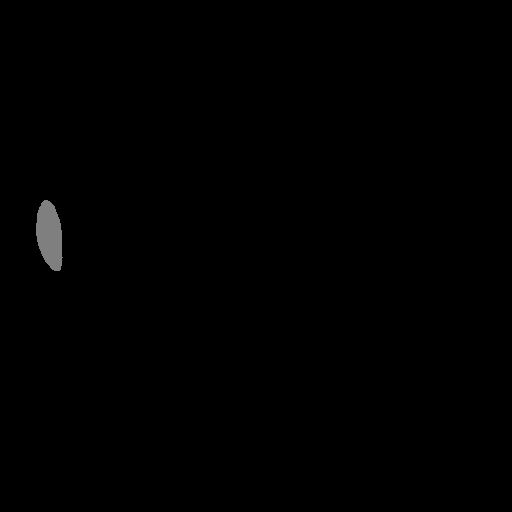

In [36]:
seg_img

In [19]:
good_slices = get_good_slices(seg_array)
good_slices

[322,
 323,
 324,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535

In [56]:
def convert_tensor_to_img(tensor, normalized=False):
    if normalized:
        arr = np.array(tensor*255, dtype=np.uint8)
    else:
        arr = np.array(tensor, dtype=np.uint8)
    print(arr.shape)
    arr = np.moveaxis(arr, [0, 1, 2], [2, 0, 1])
    print(arr.shape)
    if arr.shape[2] == 1:
        arr = arr.squeeze(2)
    img = Image.fromarray(arr)
    return img 

In [38]:
def numpy_to_pil(images):
    """
    Convert a numpy image or a batch of images to a PIL image.
    """
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]

    return pil_images


ct shape:torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
(262144, 3)
unique pixels: [[  0   0   0]
 [  0   0 128]
 [  0 128   0]
 [  0 128 128]
 [128   0   0]
 [128   0 128]
 [128 128   0]
 [128 128 128]
 [128 128 255]
 [128 255 128]
 [128 255 255]
 [255 128   0]
 [255 128 128]
 [255 255 128]
 [255 255 255]] 

 counts: [239263    247      1    249    247      3    247  18811    139      4
    135      2    137    135   2524]
torch.Size([3, 512, 512])   torch.Size([3, 512, 512])
(3, 512, 512)
(512, 512, 3)
(3, 512, 512)
(512, 512, 3)


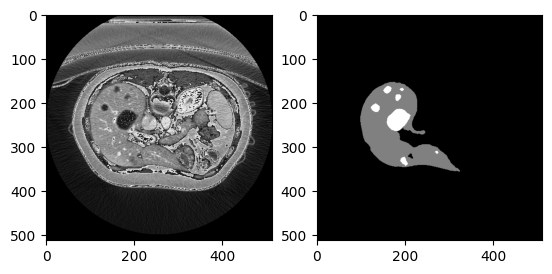

In [121]:
from training_scripts.LITS17Dataset import LITS17Dataset
from transformers import CLIPTokenizer
import os
import matplotlib.pyplot as plt

ct_dir = '/disk4/Lev/Projects/diffusion_finetuning/data/lits17/train'
vol_pkl = os.path.join(ct_dir, 'lits_train_vol_files_good_slices.pickle')
seg_pkl = os.path.join(ct_dir, 'lits_train_seg_files_good_slices.pickle')
lits17ds = LITS17Dataset(ct_dir,
                         ct_dir,
                         prompt='segmentation map of liver',
                         path_slices_for_segmap=seg_pkl,
                         path_slices_for_vol=vol_pkl)

example = lits17ds[1000]
ct = example['instance_image'] # torch tensor
print(f'ct shape:{ct.shape}')
seg = example['instance_segmap_image'] # torch tensor
print(seg.shape)
# print unique values in seg
seg_np_arr = seg.numpy().reshape(-1,3)
print(seg_np_arr.shape)
unique_pixels, counts = np.unique(seg_np_arr, axis=0, return_counts=True)
print('unique pixels:', unique_pixels,'\n\n', 'counts:', counts)


print(ct.shape, ' ', seg.shape)
ct = convert_tensor_to_img(ct, True)
seg = convert_tensor_to_img(seg, False)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(ct, cmap='gray')
ax[1].imshow(seg)
plt.show()

In [25]:
# write code to automatically reload modules
%load_ext autoreload
%autoreload 2

In [40]:
# Makes sure that the lists are aligned

lst_vol = lits17ds.ct_list_w_slices
lst_seg = lits17ds.seg_list_w_slices

i = 0
for vol, seg in zip(lst_vol, lst_seg):
    if vol[0] != seg[0].replace('segmentation', 'volume') or vol[1] != seg[1]:
        print(vol, '\n', seg, '\n\n')

In [11]:
import numpy as np
import torch

a = torch.tensor([[[0,0,0], [128,128,128], [255,255,255], [128,128,128]],
                 [[0,0,0], [128,128,128], [255,255,255], [128,128,128]],
                 [[0,0,0], [128,128,128], [255,255,255], [128,128,128]],
                 [[0,0,0], [128,128,128], [255,255,255], [128,128,128]]])



print(a.shape)
a = a.reshape(3,4,4)
print(a)
print(a.shape)
a = a.reshape(-1,3)
b = np.random.rand(512, 512, 3)
unique = np.unique(b.reshape(-1,3), axis=1, return_counts=False)
print(unique.shape)
unique= np.unique(a.numpy().reshape(-1,3), axis=0, return_counts=False)
print(f'a unique:{unique}')

torch.Size([4, 4, 3])
tensor([[[  0,   0,   0, 128],
         [128, 128, 255, 255],
         [255, 128, 128, 128],
         [  0,   0,   0, 128]],

        [[128, 128, 255, 255],
         [255, 128, 128, 128],
         [  0,   0,   0, 128],
         [128, 128, 255, 255]],

        [[255, 128, 128, 128],
         [  0,   0,   0, 128],
         [128, 128, 255, 255],
         [255, 128, 128, 128]]])
torch.Size([3, 4, 4])
(262144, 3)
a unique:[[  0   0   0]
 [128 128 128]
 [255 255 255]]


In [29]:
a = np.array([[[0,0,0], [128,128,128], [255,255,255], [128,128,128]],
                 [[0,0,0], [128,128,128], [255,255,255], [128,128,128]],
                 [[0,0,0], [128,128,128], [255,255,255], [128,128,128]],
                 [[0,0,0], [128,128,128], [255,255,255], [128,128,128]]])
a_origin = a
print(a.shape)
a = np.moveaxis(a, -1, 0)
a = torch.from_numpy(a)
a_np = np.moveaxis(a.numpy(), [0, 1, 2], [2, 0, 1])
print(f'a_origin shape:{a_origin.shape}, a_np shape:{a_np.shape}')
print(f'equal = {a_origin == a_np}')
unique= np.unique(a_np, axis=0, return_counts=False)
print(unique)


(4, 4, 3)
a_origin shape:(4, 4, 3), a_np shape:(4, 4, 3)
equal = [[[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]
  [ True  True  True]]]
[[[  0   0   0]
  [128 128 128]
  [255 255 255]
  [128 128 128]]]
